In [1]:
import re
import pandas as pd
from wordcloud import WordCloud
import nltk
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
def remove_punctuation(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(
        r"https?:\/\/(www\.)? ?[-a-zA-Z0-9@:%._\+~#=]{1,256}\. ?[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)",
        "",
        text,
    )
#     text = re.sub(r"[^@#\w\s]", "", text)
    return text

In [3]:
df = pd.read_csv('irony-labeled.csv')

In [4]:
df['comment_text'].apply(remove_punctuation)[0]

"I suspect atheists are projecting their desires when they imagine Obama is one of their number. Does anyone remember the crazy preacher with whom he was associated?  I can understand a career politician in the USA needing to feign belief to get elected, but for that purpose I'd imagine a more vanilla choice of church. He's not an atheist. He's not a liberal either."

In [124]:
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['im', 'sourcehttpwww'])
STOPWORDS = set(STOPWORDS)

Text(0.5, 1.0, 'Ironic Comments')

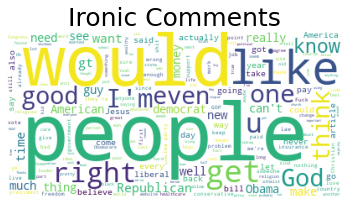

In [6]:



text_ironic = ' '.join(df.comment_text[df['label'] == 1])
wc_ironic = WordCloud(background_color='white',stopwords=STOPWORDS).generate(text_ironic)
plt.imshow(wc_ironic)
plt.axis('off')
plt.title('Ironic Comments',fontsize=25)

Text(0.5, 1.0, 'Regular Comments')

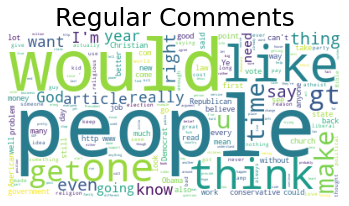

In [7]:
text = ' '.join(df.comment_text[df['label'] == -1])
wc = WordCloud(background_color='white',stopwords=STOPWORDS).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.title('Regular Comments',fontsize=25)

In [8]:
#Lista de sentenças irônicas e regulares
# sents_ironic = [item.split() for item in df.comment_text[df['label'] == 1]]
# sents_regular = [item.split() for item in df.comment_text[df['label'] == -1]]
# sents_ironic[0]

In [125]:
def preprocess(sent):

    def convert(word):
        word = re.sub(r"\W+", "", word)
        # Verifica se é um número.
        try:
            _ = float(word)
            return '<num>'
        except:
            pass

        # Verifica se é uma palavra.
        if word.isalpha():
            lower = word.lower()
            return '<stop>' if lower in STOPWORDS else lower

        # Caso contrário, é pontuação ou estranho.
        return '<weird>'

    processed = [convert(word) for word in sent]
    forbidden_words = set(('<num>', '<stop>', '<weird>'))
    return [word for word in processed if word not in forbidden_words]

In [126]:
#Lista de sentenças irônicas e regulares
sents_ironic = [preprocess(item.strip().split()) for item in df.comment_text[df['label'] == 1]]
sents_regular = [preprocess(item.strip().split()) for item in df.comment_text[df['label'] == -1]]
sents_all = [preprocess(item.strip().split()) for item in df.comment_text]

### DOC2VEC

### LDA

In [127]:
import pickle
from gensim.corpora import Dictionary
import gensim

import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

In [128]:
#Generate LDA MODEL
from gensim.models.ldamulticore import LdaMulticore
def model_dict(sents, filename, NUM_TOPICS):
    dictionary = Dictionary(sents)
    corpus = [dictionary.doc2bow(sent) for sent in sents]
    
#     pickle.dump(corpus, open(f'{filename}_corpus.pkl', 'wb'))
#     dictionary.save(f'{filename}_dictionary.gensim')
    
    ldamodel = LdaMulticore(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=30)

    return corpus, dictionary, ldamodel

In [129]:
#Check topics

def check_topics(corpus, lda_model):
    topics = lda_model.get_document_topics(corpus, per_word_topics=True)


    doc_topics, word_topics, phi_values = topics[10]
    print('Document topic:', doc_topics, "\n")

    for topic, strength in doc_topics:
        print(f'Topico: {topic}')
        print(lda_model.print_topic(topic, topn=20))

    topics = lda_model.print_topics(num_words=10)
    for topic in topics:
        print(topic)

In [130]:
def display_model(corpus, dictionary, ldamodel):  
    lda_display = pyLDAvis.gensim_models.prepare(
        ldamodel,
        corpus,
        dictionary,
        sort_topics=False,
    )
    return pyLDAvis.display(lda_display)

In [132]:
# corpus_ironic, dictionary_ironic, lda_model_ironic = model_dict(sents_ironic, 'sents_ironic')
# corpus_regular, dictionary_regular, lda_model_regular = model_dict(sents_regular, 'sents_regular')
corpus_all, dictionary_all, lda_model_all = model_dict(sents_all, 'sents_all', NUM_TOPICS=10)

In [104]:
check_topics(corpus_all)

Document topic: [(0, 0.9366517)] 

Topico: 0
0.014*"like" + 0.011*"would" + 0.007*"dont" + 0.006*"get" + 0.006*"church" + 0.005*"already" + 0.005*"family" + 0.004*"american" + 0.004*"people" + 0.004*"read" + 0.004*"article" + 0.004*"protestant" + 0.004*"arent" + 0.003*"conservatives" + 0.003*"conservative" + 0.003*"mean" + 0.003*"christmas" + 0.003*"years" + 0.002*"god" + 0.002*"books"
(0, '0.014*"like" + 0.011*"would" + 0.007*"dont" + 0.006*"get" + 0.006*"church" + 0.005*"already" + 0.005*"family" + 0.004*"american" + 0.004*"people" + 0.004*"read"')
(1, '0.014*"people" + 0.008*"church" + 0.008*"like" + 0.007*"really" + 0.006*"think" + 0.006*"god" + 0.006*"youth" + 0.006*"dont" + 0.004*"get" + 0.004*"also"')
(2, '0.011*"people" + 0.009*"thats" + 0.005*"get" + 0.005*"enough" + 0.005*"still" + 0.005*"say" + 0.005*"would" + 0.005*"thing" + 0.004*"want" + 0.004*"never"')
(3, '0.006*"better" + 0.006*"get" + 0.005*"news" + 0.005*"money" + 0.005*"article" + 0.004*"jobs" + 0.004*"know" + 0.004

In [133]:
display_model(corpus_all, dictionary_all, lda_model_all)

In [89]:
#CHECAR TOPICOS IRONICOS

topics = lda_model_ironic.get_document_topics(corpus_ironic, per_word_topics=True)

len(topics)

doc_topics, word_topics, phi_values = topics[10]
print('Document topic:', doc_topics, "\n")

for topic, strength in doc_topics:
    print(f'Topico: {topic}')
    print(lda_model_ironic.print_topic(topic, topn=20))

topics = lda_model_ironic.print_topics(num_words=10)
for topic in topics:
    print(topic)

In [83]:
display_model(corpus_ironic, dictionary_ironic, lda_model_ironic)

In [ ]:
display_model(corpus_regular, dictionary_regular, lda_model_regular)

## Ironic 

------------

In [70]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

#Ironic
#Dominant topic in each sentence

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords_ironic = format_topics_sentences(lda_model_ironic, corpus_ironic, sents_ironic)

df_dominant_topic_ironic = df_topic_sents_keywords_ironic.reset_index()
df_dominant_topic_ironic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic_ironic.head(10)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6232,"people, cant, dont, get, think, would, insuran...","[democrats, dont, know, manage, money, shocking]"
1,1,0.0,0.9357,"would, people, like, get, know, bill, pay, eve...","[like, automation, eliminated, need, manual, l..."
2,2,3.0,0.9354,"one, people, dont, like, us, guys, god, never,...","[insane, like, fox, ted, cruz, actually, intel..."
3,3,5.0,0.9238,"people, dont, america, think, get, jesus, weal...","[jesus, destroyed, satan, freedom, still, evil..."
4,4,2.0,0.9238,"people, cant, dont, get, think, would, insuran...","[reddit, liberal, brigade, would, downvote, ob..."
5,5,5.0,0.9302,"people, dont, america, think, get, jesus, weal...","[amazing, democrats, view, money, come, somewh..."
6,6,3.0,0.9559,"one, people, dont, like, us, guys, god, never,...","[makes, cringe, sure, use, memes, try, appeal,..."
7,7,1.0,0.9509,"us, democrats, republicans, dont, obama, much,...","[question, twitter, qampa, washing, sleaze, re..."
8,8,5.0,0.9403,"people, dont, america, think, get, jesus, weal...","[really, pathetic, send, shit, countries, incl..."
9,9,0.0,0.9403,"would, people, like, get, know, bill, pay, eve...","[one, utter, shock, fine, institutions, would,..."


In [71]:
#Dominant topics occurences
df_dominant_topic_ironic.Dominant_Topic.value_counts()

#Dominant topic with most occurences
dominant_topic_ironic = df_dominant_topic_ironic.Dominant_Topic.value_counts().index[0]

#Documents related to dominant topic with most occurences
df_dominant_topic_ironic[df_dominant_topic_ironic.Dominant_Topic == dominant_topic_ironic]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6232,"people, cant, dont, get, think, would, insuran...","[democrats, dont, know, manage, money, shocking]"
4,4,2.0,0.9238,"people, cant, dont, get, think, would, insuran...","[reddit, liberal, brigade, would, downvote, ob..."
15,15,2.0,0.8330,"people, cant, dont, get, think, would, insuran...","[epa, fact, non, essential]"
18,18,2.0,0.7198,"people, cant, dont, get, think, would, insuran...","[skanks, lot]"
20,20,2.0,0.8956,"people, cant, dont, get, think, would, insuran...","[cant, win, substance, win, technicality, gop,..."
...,...,...,...,...,...
509,509,2.0,0.8806,"people, cant, dont, get, think, would, insuran...","[damn, ted, must, think, gods, pussy]"
522,522,2.0,0.8949,"people, cant, dont, get, think, would, insuran...","[next, fox, news, pope, instigating, class, wa..."
524,524,2.0,0.9478,"people, cant, dont, get, think, would, insuran...","[yeah, yeah, yeah, dare, bitch, buhraaack, bit..."
525,525,2.0,0.7907,"people, cant, dont, get, think, would, insuran...","[hahahahahahahahahaha, wait, serious]"


In [31]:
#Most representative document for each topic
representativeDoc_ironic = pd.DataFrame()

groupByDominantTopic_ironic = df_topic_sents_keywords_ironic.groupby('Dominant_Topic')

for i, grp in groupByDominantTopic_ironic:
    representativeDoc_ironic = pd.concat([representativeDoc_ironic, 
                        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                        axis=0)

# Reset Index    
representativeDoc_ironic.reset_index(drop=True, inplace=True)

# Format
representativeDoc_ironic.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
representativeDoc_ironic

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9977,"would, people, like, get, know, bill, pay, eve...","[prefer, texan, back, horrible, kidney, stone,..."
1,1.0,0.9940,"us, democrats, republicans, dont, obama, much,...","[user, tilio, deleted, comment, realizing, stu..."
2,2.0,0.9919,"people, cant, dont, get, think, would, insuran...","[believe, furious, socialist, cant, roll, eyes..."
3,3.0,0.9940,"one, people, dont, like, us, guys, god, never,...","[know, earth, vastly, older, years, old, huge,..."
4,4.0,0.9839,"obama, would, like, people, dont, us, get, eve...","[gt, guts, question, even, without, namecallin..."
5,5.0,0.9941,"people, dont, america, think, get, jesus, weal...","[definitely, could, construed, form, terrorism..."


In [33]:
for i in range(len(representativeDoc_ironic)):
    print(f"Topic {i}\n", " ".join(representativeDoc_ironic["Text"][i]))
    print('=' * 80)

Topic 0
 prefer texan back horrible kidney stone didnt know never one went er excruciating pain treated wonderfully got three count em baby three shots morphine iv experience never enjoyed would recommend left handful prescriptions ct scan right kind scan went home high kite days passed good woo bill comes first like woah shit called complained er specifically ask repeatedly much scan would cost repeatedly question refused answered doctors nurses radiologists whatever theyre called even lady came get personal info ask credit card pay much could afford right authorized wouldnt explain exactly paying right finally decided wanted card file sooo bill comes scan alone bucks scan entire rest treatment would probably paid gladly wonderful care got knew uninsured going knew ers expensive time horrible pain scared shitless didnt care made choices would live grand scan seemed unreasonable also found later scans like arent necessary kidney stones often arent done unless youre peeing blood wtf fun

-----------

## Regular

-----------

In [72]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
#Ironic
#Dominant topic in each sentence


df_topic_sents_keywords_regular = format_topics_sentences(lda_model_regular, corpus_regular, sents_regular)

df_dominant_topic_regular = df_topic_sents_keywords_regular.reset_index()
df_dominant_topic_regular.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic_regular.head(10)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.9773,"dont, even, would, people, article, get, gt, o...","[suspect, atheists, projecting, desires, imagi..."
1,1,0.0,0.9809,"would, people, think, like, get, money, system...","[funny, arguments, shills, making, still, clos..."
2,2,2.0,0.9711,"think, like, dont, one, god, us, christian, ev...","[truly, following, patterns, mandarins, took, ..."
3,3,5.0,0.9665,"dont, even, would, people, article, get, gt, o...","[air, pressure, dropping, altitude, goes, high..."
4,4,4.0,0.9635,"like, people, think, see, dont, would, get, yo...","[absolutely, think, wed, hard, pressed, find, ..."
5,5,0.0,0.7214,"would, people, think, like, get, money, system...","[would, win]"
6,6,3.0,0.4950,"people, like, really, god, make, one, would, d...","[yeah, didnt, get, far, article, fills, sadness]"
7,7,5.0,0.9439,"dont, even, would, people, article, get, gt, o...","[kind, heartless, person, voted, sick, enough,..."
8,8,2.0,0.8324,"think, like, dont, one, god, us, christian, ev...","[god, hope, keep, kicking]"
9,9,4.0,0.9399,"like, people, think, see, dont, would, get, yo...","[cant, work, part, timers, crazy, hours, law, ..."


In [73]:
#Dominant topics occurences
df_dominant_topic_regular.Dominant_Topic.value_counts()

#Dominant topic with most occurences
dominant_topic_regular = df_dominant_topic_regular.Dominant_Topic.value_counts().index[0]

#Documents related to dominant topic with most occurences
df_dominant_topic_regular[df_dominant_topic_regular.Dominant_Topic == dominant_topic_regular]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
17,17,1.0,0.8805,"people, would, like, time, party, obama, dont,...","[people, offended, redskins, white, liberals, ..."
18,18,1.0,0.9442,"people, would, like, time, party, obama, dont,...","[havent, read, article, yet, absolutely, clue,..."
27,27,1.0,0.9599,"people, would, like, time, party, obama, dont,...","[science, statistics, opposed, carl, rove, bli..."
32,32,1.0,0.4735,"people, would, like, time, party, obama, dont,...","[know, hear, right, yes, continues, rant]"
41,41,1.0,0.9507,"people, would, like, time, party, obama, dont,...","[graduated, high, school, still, use, skills, ..."
...,...,...,...,...,...
1387,1387,1.0,0.9711,"people, would, like, time, party, obama, dont,...","[wow, got, fox, news, mention, fox, news, even..."
1388,1388,1.0,0.8601,"people, would, like, time, party, obama, dont,...","[welcome, new, congress, old, congress]"
1389,1389,1.0,0.9690,"people, would, like, time, party, obama, dont,...","[still, incredibly, lucrative, investment, koc..."
1402,1402,1.0,0.9437,"people, would, like, time, party, obama, dont,...","[would, make, happy, sounds, like, might, move..."


In [35]:
#Most representative document for each topic
representativeDoc_regular = pd.DataFrame()

groupByDominantTopic_regular = df_topic_sents_keywords_regular.groupby('Dominant_Topic')

for i, grp in groupByDominantTopic_regular:
    representativeDoc_regular = pd.concat([representativeDoc_regular, 
                        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                        axis=0)

# Reset Index    
representativeDoc_regular.reset_index(drop=True, inplace=True)

# Format
representativeDoc_regular.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
representativeDoc_regular

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9976,"would, people, think, like, get, money, system...","[infuriates, people, reddit, use, tired, old, ..."
1,1.0,0.9971,"people, would, like, time, party, obama, dont,...","[sick, tired, whole, media, cabal, bullshit, e..."
2,2.0,0.9949,"think, like, dont, one, god, us, christian, ev...","[yeah, say, moderate, saw, slideshow, would, s..."
3,3.0,0.9964,"people, like, really, god, make, one, would, d...","[pretty, much, claim, whatever, wants, blessin..."
4,4.0,0.9975,"like, people, think, see, dont, would, get, yo...","[surprising, article, takes, antiinvestor, sta..."
5,5.0,0.9965,"dont, even, would, people, article, get, gt, o...","[condescending, pretentious, little, brat, nei..."


In [36]:
for i in range(len(representativeDoc_regular)):
    print(f"Topic {i}\n", " ".join(representativeDoc_regular["Text"][i]))
    print('=' * 80)

Topic 0
 infuriates people reddit use tired old comment atheists bad religious zealots really gt witch killings gtenoch adeboye evangelical pastor nigeria promotes existence witches wizards resulting torture death young children others nigeria wider african continent also spread europe see gton christmas day kristy bamu found paramedics bathroom east london highrise flat body mutilated teeth missing covered deep cuts bruising starved deprived water sleep punched kicked repeatedly floor tiles smashed head teeth knocked hammer pair pliers used twist ear last four days life suffered acts unspeakable savagery viciously inflicted upon man called uncle one sisters gtwhy gtbecause eric bikubi magalie bamu boys family members convinced witch debbie ariyo executive director africans unite child abuse explains boom pentecostal churches leading children accused witchcraft gtan average eight children year greater london victims abuse based witchcraftstyle exorcisms reflects cases resulting police 